In [2]:
pip install ..

Processing i:\mutiomics\pythonproject
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hacca: filename=hacca-0.0.4-py3-none-any.whl size=14549 sha256=be50d5568c7b6b54f0f6765390dc7a239a793ad49b3fd92c6336f28eb889de33
  Stored in directory: C:\Users\28123\AppData\Local\Temp\pip-ephem-wheel-cache-rm18w80r\wheels\f4\b6\c3\58ac8cb433abb98add080490f98bd85a3d5a576d67fc039979
Successfully built hacca
  Attempting uninstall: hacca
    Found existing installation: hacca 0.0.4
    Uninstalling hacca-0.0.4:
      Successfully uninstalled hacca-0.0.4
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import hacca
import scanpy as sc
from hacca.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# <font size=2>**set working directory** 

In [188]:
#### dir name
cwd="I:\\mutiomics\\ICC\\run2_WT\\KO1"
data_path = os.path.join(cwd, 'data')
work_dir = os.path.join(cwd, 'work')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

# <font size=2>**Read in data** 
# <font size=1>We align b_prime to a in this case, a is MSI-MALDI and b_prime is 10X Visum.

In [190]:
a_h5ad = sc.read_h5ad(os.path.join(cwd, "ITO_KO.h5ad"))
b_prime_h5ad = sc.read_h5ad(os.path.join(cwd,"anndata_KO.h5ad"))

# <font size=2>**Step 1: Data preprocession.**
# <font size=1>MSI-MALDI has a blank area, clustered as cluster 0, remove it

In [193]:
a_h5ad = a_h5ad[a_h5ad.obs['clusters'] != "3"]
#a_h5ad = a_h5ad[a_h5ad.obs['clusters'] != "4"]
a_h5ad.obs["leiden"] =  a_h5ad.obs["clusters"]
b_prime_h5ad.obs["leiden"] = b_prime_h5ad.obs["combine_cluster"]

C:\Users\28123\AppData\Local\Temp\ipykernel_9764\3769698028.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a_h5ad.obs["leiden"] =  a_h5ad.obs["clusters"]


# <font size=1>lets take a look at a and b_prime

a AnnData object with n_obs × n_vars = 16463 × 2635
    obs: 'clusters', 'batch', 'leiden'
    uns: 'clusters_colors', 'leiden_colors'
    obsm: 'spatial'
b_prime AnnData object with n_obs × n_vars = 16610 × 17952
    obs: 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'batches', 'combine_cluster', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'combine_cluster_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


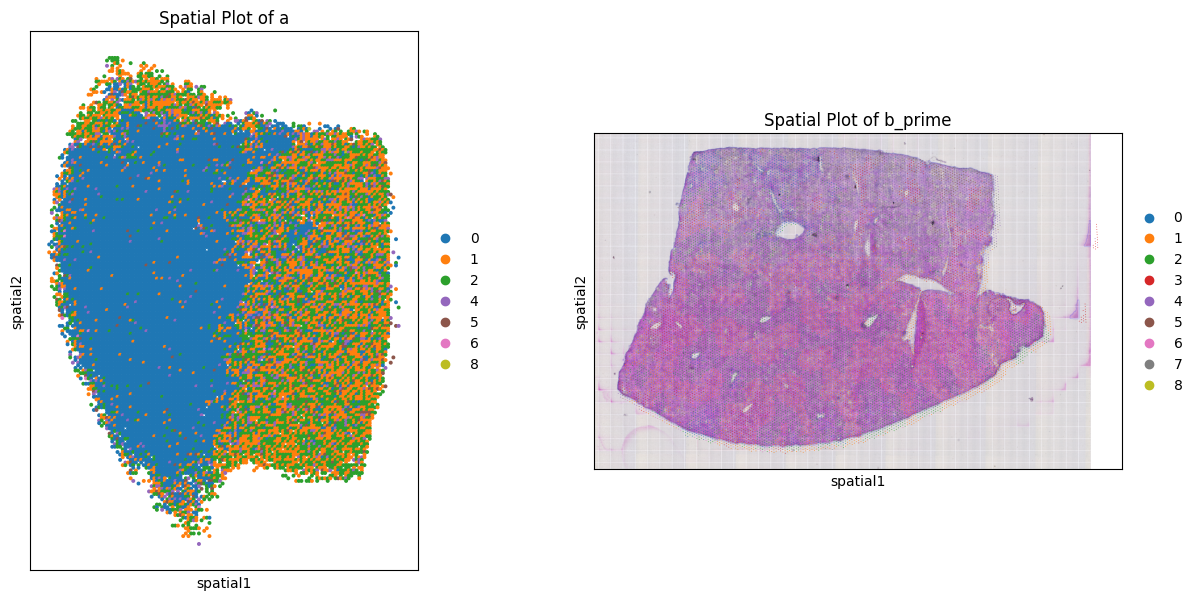

In [194]:
print("a",a_h5ad)
print("b_prime",b_prime_h5ad)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(a_h5ad, img_key = "hires", color="leiden", spot_size=1.5, ax=axs[0], show=False)
axs[0].set_title('Spatial Plot of a')
sc.pl.spatial(b_prime_h5ad, img_key = "hires", color="leiden", spot_size=1.5,ax=axs[1],show=False)
axs[1].set_title('Spatial Plot of b_prime')
plt.show()

# <font size=1> scale spatial data of a and b_prime,defalut [0-500]

In [195]:
b_prime_spatial = pd.DataFrame(b_prime_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(a_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

# <font size=1> turn a and b_prime into hacca.Data format: Data(X(n,m),D(n,2),Lable(n,1)). n is the number of spots and m is the number of features

In [196]:
a = Data(X=a_h5ad.X, D = a_spatial, Label=a_h5ad.obs['leiden'].to_numpy())
b_prime = Data(X=b_prime_h5ad.X.toarray(), D = b_prime_spatial, Label=b_prime_h5ad.obs['leiden'].to_numpy())

# <font size=1>Ok lets hacca. This is the classic hacca, morphopogical alignment is peformed by 1.manual gross algnment and 2.further alignment.combined feature and morphological alignment is performed by ICP

# <font size=2>**Step2: gross manual alignment** 
# <font size=1> In this step, 2 windows of morphological plots will shown. You should manually choose 3 pairs of feature points by clicking. In this case, feature points is shown in red box.

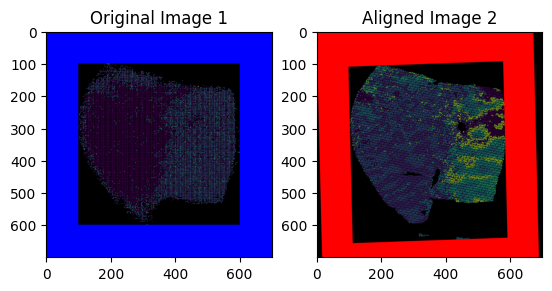

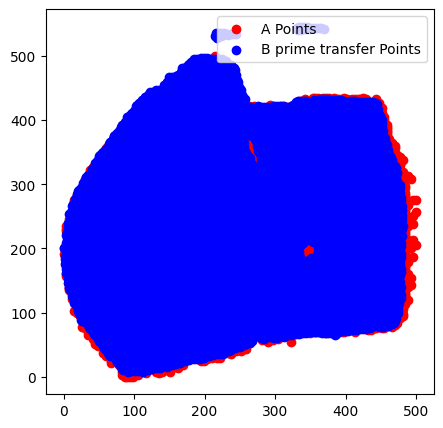

In [197]:
manual_gross_further_ICP_work_dir = os.path.join(work_dir, 'manual_gross_further')
if not os.path.exists(manual_gross_further_ICP_work_dir):
    os.makedirs(manual_gross_further_ICP_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_gross_further_ICP_work_dir,dot_size=1)

# <font size=2>**Step3: further alignment**

In [198]:
_b_prime = hacca.further_alignment(a, _b_prime)

I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values
I:\mutiomics\pythonProject\.venv\lib\site-packages\hacca\alignment.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

# <font size=2>**Step4: combined feature and morphological alignment**

In [199]:
_a=a

In [200]:
_a,_b_prime = hacca.icp_3d_alignment(a,_b_prime,low_threshold=0.2,dist_min=0.2,high_threshold=0.95)

anchor_points_pairs 191


I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
I:\mutiomics\pythonProject\.venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100


# <font size=1> b_predict is the aligned b_prime, lets see b_predict

In [201]:
_a.X.shape

(16463, 2635)

In [214]:
df3  = pd.read_csv("I:\\mutiomics\\ICC\\BQ-SXT20240702-空代50um-1-沈晓天-检测分析交付\\03\\anno-matrix.csv")


In [215]:
df3
print(df3.index) 
print(a_h5ad.obs.index)

RangeIndex(start=0, stop=19626, step=1)
Index(['71', '72', '73', '74', '95', '97', '98', '99', '101', '126',
       ...
       '19528', '19534', '19552', '19554', '19555', '19557', '19573', '19575',
       '19583', '19622'],
      dtype='object', length=16463)


# <font size=1> common sample of df3 abd a_h5ad should be found and selected

In [216]:
indices_to_select = a_h5ad.obs.index.astype(int)
df3 = df3.iloc[indices_to_select, :]
df3 = df3.drop(df3.columns[-1], axis=1)
_a.X = df3.values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


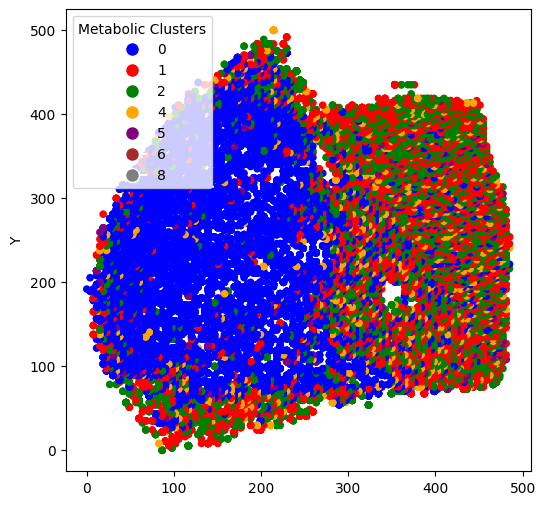

In [217]:
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=manual_gross_further_ICP_work_dir)
hacca.plot_b_predict(b_predict,manual_gross_further_ICP_work_dir)

In [218]:
b_predict.X.shape

(16610, 254)

In [219]:
df3.columns

Index(['Taurine', '2-Acetylthiazole', 'Pyroglutamic acid', 'Adenine',
       'N-Nitrosoproline', 'Xanthine', '3-Sulfinoalanine',
       'Homocysteinesulfinic acid', 'Phosphoenolpyruvic acid',
       'S-Carboxymethyl-L-cysteine',
       ...
       'Unnamed: 244', 'Tomatine', 'CL(8:0/8:0/8:0/18:0)',
       'CDP-DG(18:2(9Z,12Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))',
       'b-Chlorogenin 3-[4''-(2'''-glucosyl-3'''-xylosylglucosyl)galactoside]',
       'CDP-DG(18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'CL(8:0/8:0/8:0/20:0)',
       'Ganglioside GM3 (d18:1/12:0)', 'Ganglioside GA2 (d18:1/24:1(15Z))',
       'Ganglioside GA2 (d18:1/24:0)'],
      dtype='object', length=254)

# <font size=2>**Step5: merge b_prime and b_predict to generate a new merge_adata**

In [220]:
b_prime.X.shape

(16610, 17952)

In [221]:
Label_merge = np.vstack((b_prime.Label,b_predict.Label)).T
Label_merge = pd.DataFrame(Label_merge,columns=["b_prime_label","a_label"])
X_merge = np.hstack((b_prime.X,b_predict.X))
merge_var = np.hstack((b_prime_h5ad.var_names, df3.columns))
merge_var = pd.DataFrame(index=merge_var)
merge_adata = sc.AnnData(X=X_merge, var=merge_var, obs=Label_merge)
merge_adata.obsm=b_prime_h5ad.obsm
merge_adata.uns =b_prime_h5ad.uns

I:\mutiomics\pythonProject\.venv\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# <font size=1> Now haCCA is finished. Lets take a look at b_prime and a's label distribution in merge_adata

In [222]:
merge_var

""
Xkr4
Rp1
Sox17
Gm6085
Mrpl15
...
"CDP-DG(18:1(11Z)/22:6(4Z,7Z,10Z,13Z,16Z,19Z))"
CL(8:0/8:0/8:0/20:0)
Ganglioside GM3 (d18:1/12:0)
Ganglioside GA2 (d18:1/24:1(15Z))


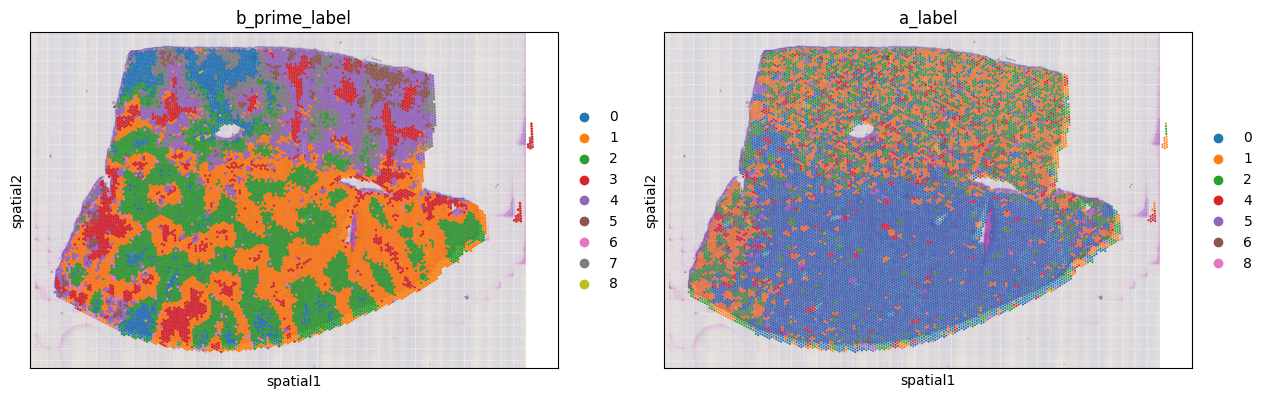

In [223]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(merge_adata, img_key = "hires", color="b_prime_label", spot_size=5,ax=axs[0],show=False)
axs[0].set_title('b_prime_label')
sc.pl.spatial(merge_adata, img_key = "hires", color="a_label", spot_size=4,ax=axs[1],show=False)
axs[1].set_title('a_label')
plt.show()

# <font size=1> Lets take a look at b_prime and a's label distribution in merge_adata. 
# <font size=1> We select gene "Vxn" from b_prime and metabolite "881.51323" from a


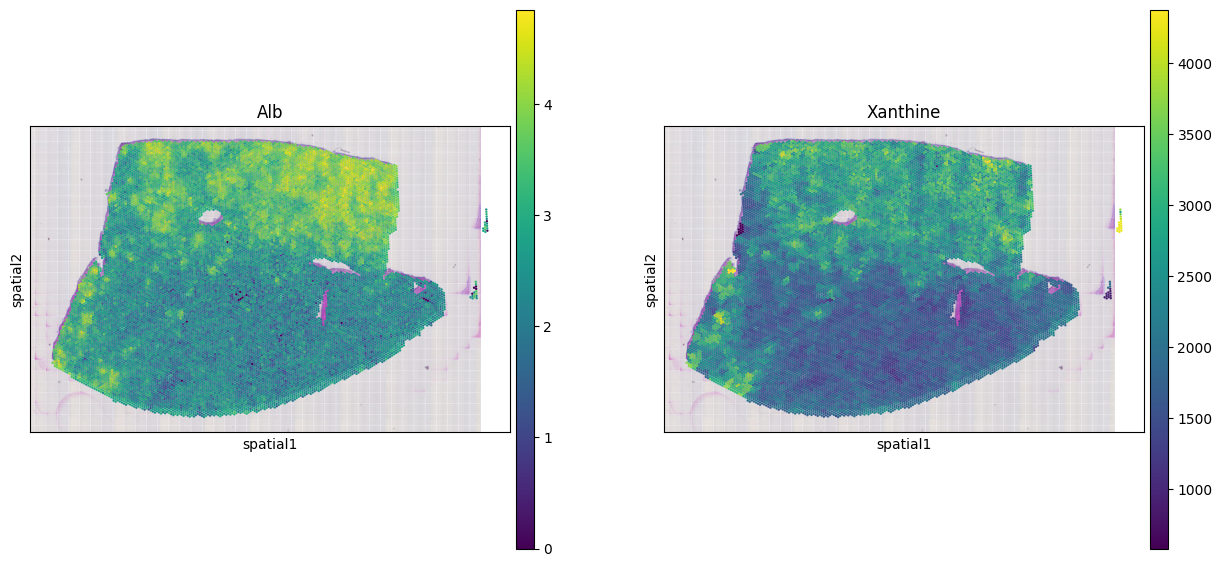

In [224]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
sc.pl.spatial(merge_adata,color="Scd1",title="Alb",size=1,show=False, alpha_img=1,ax=axs[0])
sc.pl.spatial(merge_adata,color="Oleic acid",title="Xanthine",size=1,show=False, alpha_img=1,ax=axs[1])
plt.show()


In [225]:
merge_adata.write("I:\\mutiomics\\ICC\\run2_WT\\KO1\\KO1_merge.h5ad")